# Micrograd Implementation Notebook

## Necessary libraries

In [1]:
import math
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

## Derivative with one input

In [2]:
def f(x):
    return 3*x**2 - 4*x + 5

f(3.0)

20.0

In [3]:
xs = np.arange(-5, 5, 0.25)
ys = f(xs)
ys

array([100.    ,  91.6875,  83.75  ,  76.1875,  69.    ,  62.1875,
        55.75  ,  49.6875,  44.    ,  38.6875,  33.75  ,  29.1875,
        25.    ,  21.1875,  17.75  ,  14.6875,  12.    ,   9.6875,
         7.75  ,   6.1875,   5.    ,   4.1875,   3.75  ,   3.6875,
         4.    ,   4.6875,   5.75  ,   7.1875,   9.    ,  11.1875,
        13.75  ,  16.6875,  20.    ,  23.6875,  27.75  ,  32.1875,
        37.    ,  42.1875,  47.75  ,  53.6875])

Text(0.5, 1.0, '$f(x)=3x^2-4x+5$')

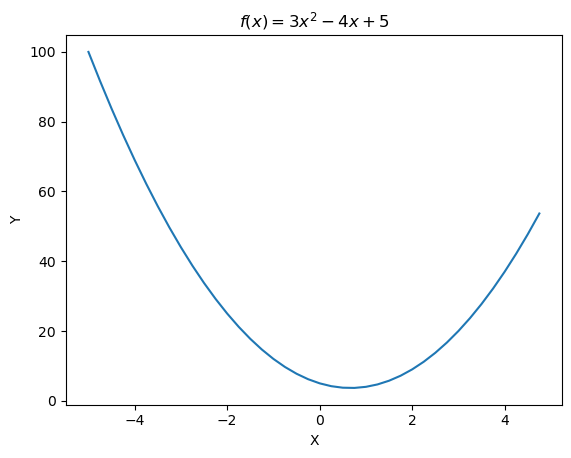

In [4]:
plt.plot(xs, ys)
plt.xlabel('X')
plt.ylabel('Y')
plt.title('$f(x)=3x^2-4x+5$')

No one in real life tries to find the derivatives by hand. To calculate it we need to understand what the derivative does.

For example we can take our `x=3` and a very small `h=0.001`. If we plug it to our function $f(x+h)$ we will see that the value has slightly increased. Therefore slightly going in a positive direction will increase the value for our function. 

We can take $\large\frac{f(x+h)-f(x)}{h}$ to obrain the slope of the function, which is roughly 14.
If we differentiate by hand, we can see that the approximation is correct:

$f(x)'=6x-4$

$f(3.0)=18-4=14$

In [5]:
h = 0.00000001
x = 3.0
f(x + h)

20.00000014

In [6]:
(f(x + h) - f(x)) / h

14.00000009255109

In [7]:
h = 0.00000001
x = -3.0
f(x + h)

43.999999779999996

In [8]:
(f(x + h) - f(x)) / h

-22.00000039920269

We can find where the slop is zero by solving the $f(x)'=0$

The answer is $\large\frac{2}{3}$

In [9]:
h = 0.00000001
x = 2 / 3
f(x + h)

3.666666666666667

In [10]:
(f(x + h) - f(x)) / h

0.0

## Derivative with Multiple Inputs

In [11]:
h=0.0001
a = 2.0
b = -3.0
c = 10.0
d1 = a * b + c
print('d1:',d1)
a += h # Derivative of d with respect to a
d2 = a * b + c
print('d2:',d2)
print('slope: ', (d2 - d1) / h)

d1: 4.0
d2: 3.999699999999999
slope:  -3.000000000010772


## Value object for micrograd

In [73]:
class Value:
    def __init__(self, data, _children=(), _op='', label=''):
        self.data = data
        self._prev = set(_children)
        self._op = _op
        self.label = label
        self.grad=0
    
    def __repr__(self):
        return f"Value(data={self.data})"
    
    def __add__(self, other):
        output = Value(self.data + other.data, (self, other), '+')
        return output
    
    def __mul__(self, other):
        output = Value(self.data * other.data, (self, other), '*')
        return output

    def tanh(self):
        n = self.data
        t = (math.exp(2*n)-1) / (math.exp(2*n)+1)
        output=Value(t, (self, ), 'tanh')
        return output
        

In [56]:
a = Value(2.0, label='a')
b = Value(-3.0, label='b')
c = Value(10.0, label='c')
e = a * b
e.label = 'e'
d = e + c  # a.__mul__(b).__add__(c)
d.label='d'
f = Value(-2.0, label='f')
L = d * f
L.label='L'

## Vizualization of Propogation

In [14]:
from graphviz import Digraph


def trace(root):
    # Build the set of all nodes and edges in a graph
    nodes, edges = set(), set()

    def build(node):
        if node not in nodes:
            nodes.add(node)
            for child in node._prev:
                edges.add((child, node))
                build(child)

    build(root)
    return nodes, edges


def draw_dot(root):
    dot = Digraph(format='svg', graph_attr={'rankdir':
                                            'LR'})  # LR means Left-to-Right
    nodes, edges = trace(root)
    for n in nodes:
        uid = str(id(n))
        # If value, create a rectangular node
        dot.node(name=uid, label=f'{{ {n.label} | data {n.data:.4f} | grad {n.grad:.4f} }}', shape='record')
        if n._op:
            # If operation, create circular node
            dot.node(name=uid + n._op, label=n._op)
            dot.edge(uid + n._op, uid)

    for n1, n2 in edges:
        dot.edge(str(id(n1)),
                 str(id(n2)) + n2._op)  # Connect Nodes throught the operation

    return dot

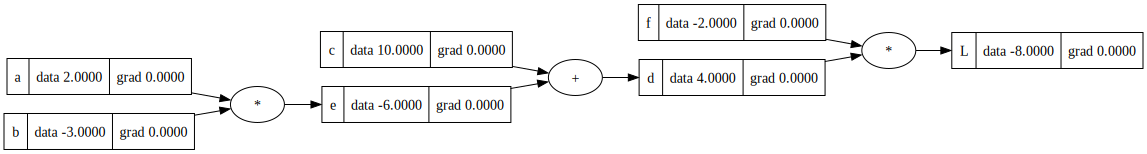

In [25]:
draw_dot(L)

## Manual Backpropogation

$\large\frac{dL}{dL}=1$

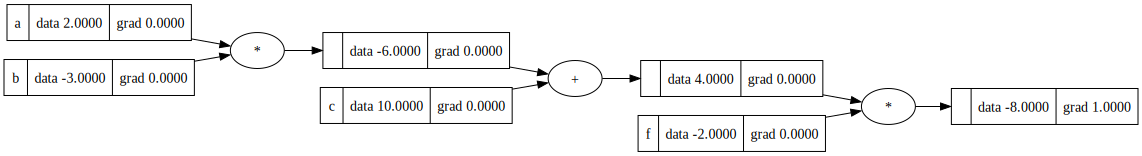

In [59]:
L.grad=1
draw_dot(L)

$L = df$

$\large\frac{dL}{dd}=f=-2;  \large\frac{dL}{df}=d=4$

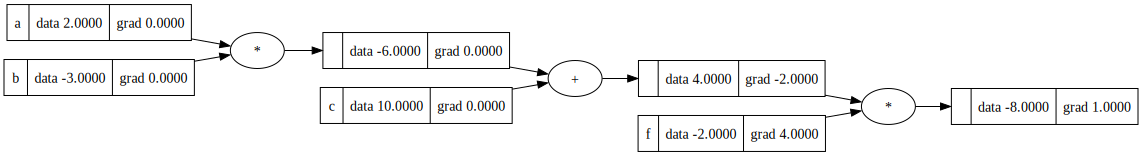

In [60]:
f.grad=4.0
d.grad=-2.0
draw_dot(L)

$\large\frac{dL}{dc}=\frac{dL}{dd}\frac{dd}{dc}=-2.0*1=-2.0$

$\large\frac{dL}{de}=\frac{dL}{dd}\frac{dd}{de}=-2.0*1=-2.0$

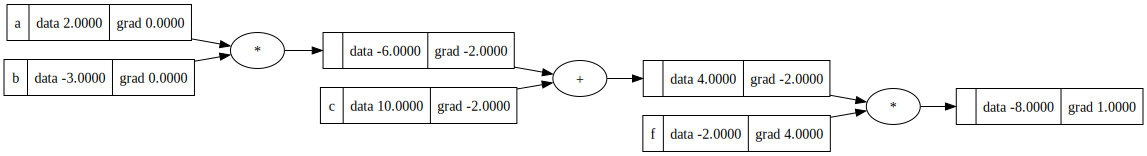

In [61]:
c.grad=-2.0
e.grad=-2.0
draw_dot(L)

$\large\frac{dL}{da}=\frac{dL}{dd}\frac{dd}{de}\frac{de}{da}=(-2.0)(1.0)(-3.0)=6.0$

$\large\frac{dL}{db}=\frac{dL}{dd}\frac{dd}{de}\frac{de}{db}=(-2.0)(1.0)(2.0)=-4.0$

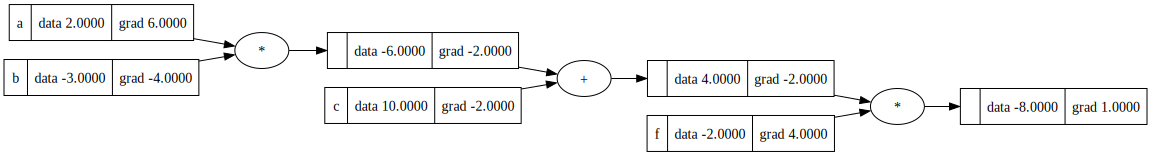

In [62]:
a.grad=6.0
b.grad=-4.0
draw_dot(L)

In [63]:
a.data += 0.01 * a.grad
b.data += 0.01 * b.grad
c.data += 0.01 * c.grad
f.data += 0.01 * f.grad
e = a * b
d = e + c
L = d * f
print(L.data)

-7.286496


In [65]:
def gradient_check():
    h = 0.000001
    a = Value(2.0, label='a')
    b = Value(-3.0, label='b')
    c = Value(10.0, label='c')
    e = a * b
    e.label = 'e'
    d = e + c  # a.__mul__(b).__add__(c)
    d.label = 'd'
    f = Value(-2.0, label='f')
    L = d * f
    L.label = 'L'
    L1 = L.data

    a = Value(2.0, label='a')
    b = Value(-3.0, label='b')
    c = Value(10.0, label='c')
    e = a * b
    e.label = 'e'
    d = e + c  # a.__mul__(b).__add__(c)
    d.label = 'd'
    f = Value(-2.0, label='f')
    L = d * f
    L.label = 'L'
    L2 = L.data

    print((L2 - L1) / h)


sample_function()

0.0


## Backpropogating through a neuron

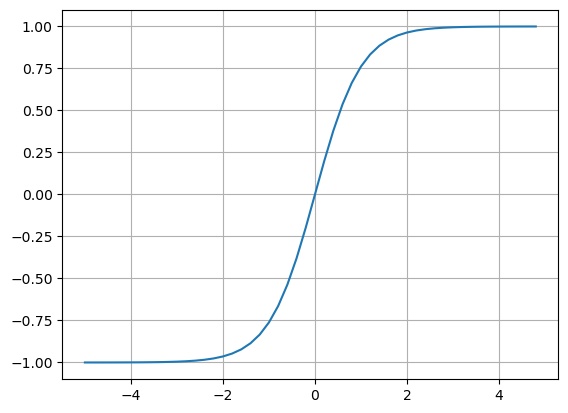

In [66]:
plt.plot(np.arange(-5.0, 5, 0.2), np.tanh(np.arange(-5, 5, 0.2)))
plt.grid();

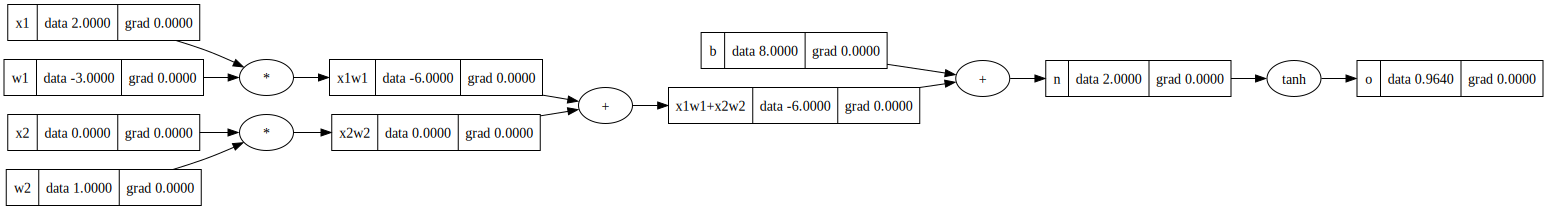

In [84]:
# Inputs
x1 = Value(2.0, label='x1')
x2 = Value(0.0, label='x2')

# Weights
w1 = Value(-3.0, label='w1')
w2 = Value(1.0, label='w2')

# Bias
b = Value(8.0, label='b')

# x1w1 + x2w2 + b
x1w1 = x1 * w1
x1w1.label = 'x1w1'
x2w2 = x2 * w2
x2w2.label = 'x2w2'
x1w1x2w2 = x1w1 + x2w2
x1w1x2w2.label = 'x1w1+x2w2'
n = x1w1x2w2 + b
n.label = 'n'
o = n.tanh()
o.label='o'

draw_dot(o)

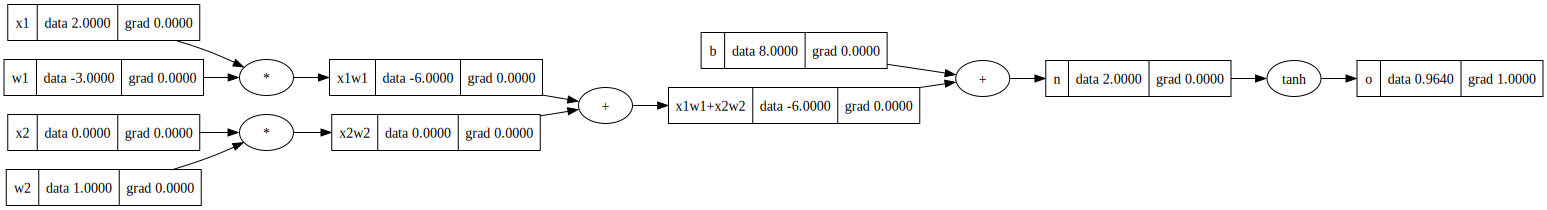

In [85]:
o.grad=1.0
draw_dot(o)

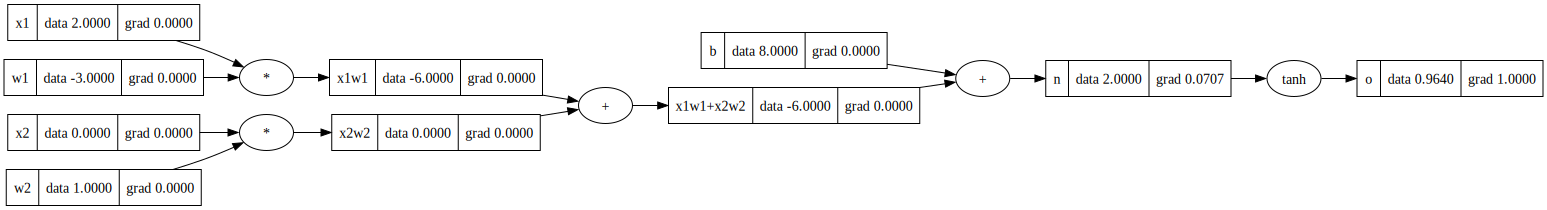

In [87]:
n.grad = 1-o.data**2
draw_dot(o)

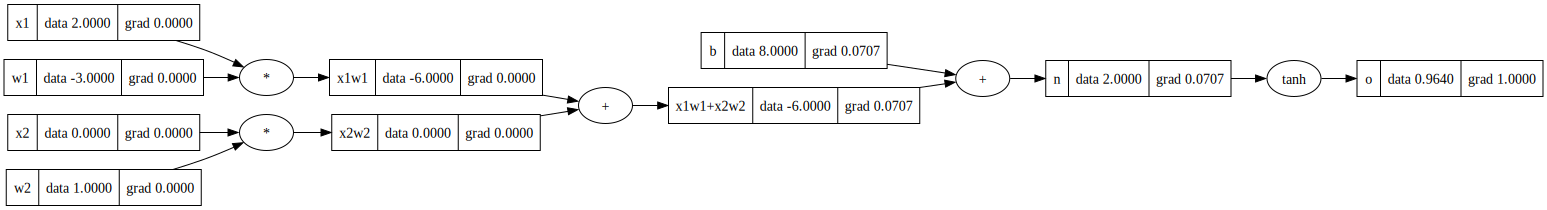

In [88]:
b.grad=0.0707
x1w1x2w2.grad=0.0707
draw_dot(o)

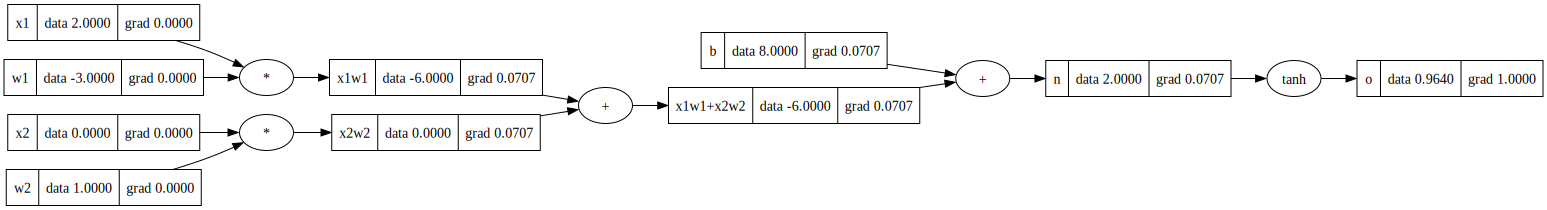

In [89]:
x1w1.grad=0.0707
x2w2.grad=0.0707
draw_dot(o)

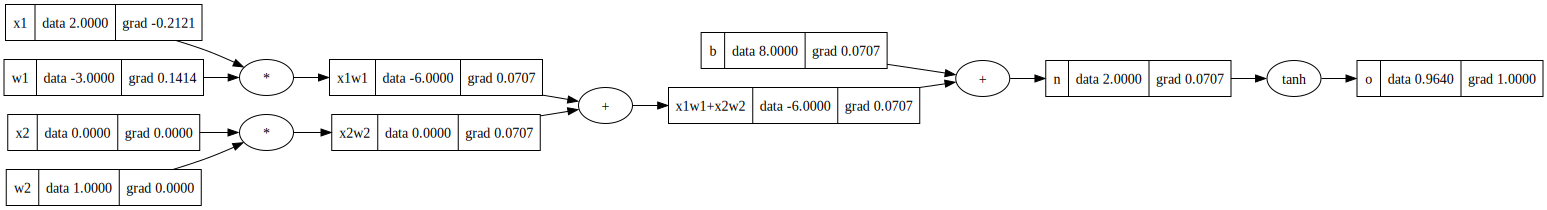

In [90]:
x1.grad = x1w1.grad*w1.data
w1.grad = x1w1.grad*x1.data
draw_dot(o)

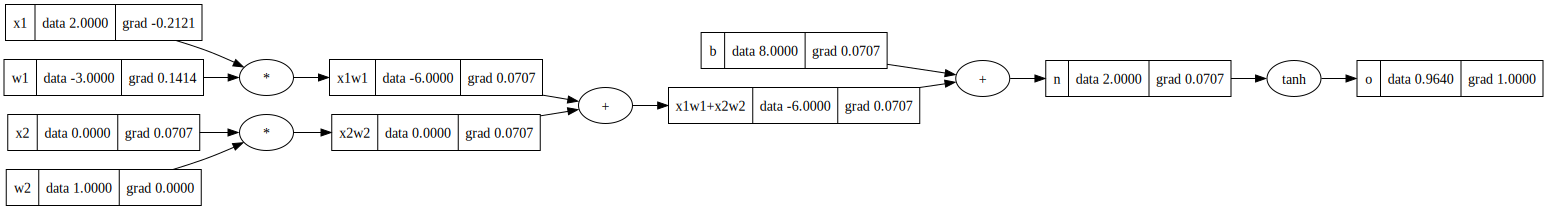

In [91]:
x2.grad = x2w2.grad*w2.data
w2.grad = x2w2.grad*x2.data
draw_dot(o)